<a href="https://colab.research.google.com/github/giacomosansoni/Siamese_Network_Artist_Similarity/blob/main/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from tensorflow import keras as tfk
from keras import applications
from keras import layers as tfkl
from keras import losses
from keras import optimizers
from keras import metrics
from keras import Model
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Thesis/Thesis/

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1D4FFhBTYn6QfBuxB5OXjn7JgI3z14YxH/Thesis


In [3]:

'''
def distance(x, y, name):
    return tfkl.Lambda(lambda tensors: tf.reduce_sum(tf.square(tensors[0] - tensors[1]), axis=-1), name=name)([x, y])


@tf.function
def triplet_loss(y_true, y_pred):
    margin = 0.5
    ap_distance, an_distance = y_pred[:, 0], y_pred[:, 1]
    loss_value = ap_distance - an_distance + margin
    return tf.maximum(loss_value, 0.0)
'''

def cosine_similarity(x, y):
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return K.sum(x * y, axis=-1)

def distance(x, y, name):
    return tfkl.Lambda(lambda tensors: 1 - cosine_similarity(tensors[0], tensors[1]), name=name)([x, y])

@tf.function
def triplet_loss(y_true, y_pred):
    margin = 0.9
    ap_distance, an_distance = y_pred[:, 0], y_pred[:, 1]
    loss_value = ap_distance - an_distance + margin
    return tf.maximum(loss_value, 0.0)


def compute_triplet_accuracy(model, triplets):
    """
    Computes the accuracy of the model based on the proportion of triplets
    where the distance with the positive example is less than the distance
    with the negative example.

    Args:
    - model: The trained Siamese network model.
    - triplets: A numpy array of shape (num_triplets, 3, sequence_length, 1)
                where the second dimension corresponds to the anchor, positive,
                and negative examples.

    Returns:
    - accuracy: The proportion of correctly ranked triplets.
    """
    anchors = np.expand_dims(triplets[:, :, 0], axis=-1)
    positives = np.expand_dims(triplets[:, :, 1], axis=-1)
    negatives = np.expand_dims(triplets[:, :, 2], axis=-1)

    # Get the predicted distances
    distances = model.predict([anchors, positives, negatives])

    ap_distances = distances[:, 0]
    an_distances = distances[:, 1]

    # Compute the number of correct triplets
    correct_triplets = np.sum(ap_distances < an_distances)

    # Compute the accuracy
    accuracy = correct_triplets / triplets.shape[0]

    return accuracy


In [ ]:
input_shape = (61440,1)

def build_1DCNN_net(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor with regularization and batch normalization
    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn) # tfkl.AveragePooling1D(pool_size=2)(cnn)
    cnn = tfkl.BatchNormalization()(cnn)

    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(cnn)
    cnn = tfkl.MaxPooling1D()(cnn) # tfkl.AveragePooling1D(pool_size=2)(cnn)
    cnn = tfkl.BatchNormalization()(cnn)

    cnn = tfkl.Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(cnn)
    cnn = tfkl.MaxPooling1D()(cnn) # tfkl.AveragePooling1D(pool_size=2)(cnn)
    cnn = tfkl.BatchNormalization()(cnn)

    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(cnn)
    cnn = tfkl.MaxPooling1D()(cnn) # tfkl.AveragePooling1D(pool_size=2)(cnn)
    cnn = tfkl.BatchNormalization()(cnn)

    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(cnn)
    cnn = tfkl.MaxPooling1D()(cnn) # tfkl.AveragePooling1D(pool_size=2)(cnn)
    cnn = tfkl.BatchNormalization()(cnn)

    cnn = tfkl.Conv1D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(cnn)
    cnn = tfkl.MaxPooling1D()(cnn) # tfkl.AveragePooling1D(pool_size=2)(cnn)
    cnn = tfkl.BatchNormalization()(cnn)

    cnn = tfkl.Conv1D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(cnn)
    cnn = tfkl.MaxPooling1D()(cnn) # tfkl.AveragePooling1D(pool_size=2)(cnn)
    cnn = tfkl.BatchNormalization()(cnn)

    cnn = tfkl.Conv1D(16, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(cnn)
    cnn = tfkl.MaxPooling1D()(cnn) # tfkl.AveragePooling1D(pool_size=2)(cnn)
    cnn = tfkl.BatchNormalization()(cnn)

    cnn = tfkl.Conv1D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(cnn)
    cnn = tfkl.BatchNormalization()(cnn)

    flatten = tfkl.Flatten()(cnn)
    dropout = tfkl.Dropout(0.5, seed=40)(flatten)

    output_layer = tfkl.Dense(256, activation='relu')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='cnn')

    return model

cnn = build_1DCNN_net((61440,1))
cnn.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 61440, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 61440, 128)        512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 30720, 128)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 30720, 128)        512       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 30720, 128)        49280     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 15360, 128)        0       

In [ ]:
anchor_input = tfkl.Input(name="anchor", shape=input_shape)
positive_input = tfkl.Input(name="positive", shape=input_shape)
negative_input = tfkl.Input(name="negative", shape=input_shape)

A = cnn(anchor_input)
P = cnn(positive_input)
N = cnn(negative_input)

ap_distance = distance(A, P, name="ap_distance")
an_distance = distance(A, N, name="an_distance")

distances = tfkl.Lambda(lambda tensors: tf.stack(tensors, axis=1), name="distances")([ap_distance, an_distance])

siamese_network = tfk.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)
siamese_network.compile(optimizer=tf.keras.optimizers.Adam(), loss=triplet_loss)
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor (InputLayer)         [(None, 61440, 1)]           0         []                            
                                                                                                  
 positive (InputLayer)       [(None, 61440, 1)]           0         []                            
                                                                                                  
 negative (InputLayer)       [(None, 61440, 1)]           0         []                            
                                                                                                  
 cnn (Functional)            (None, 256)                  650840    ['anchor[0][0]',              
                                                                     'positive[0][0]',        

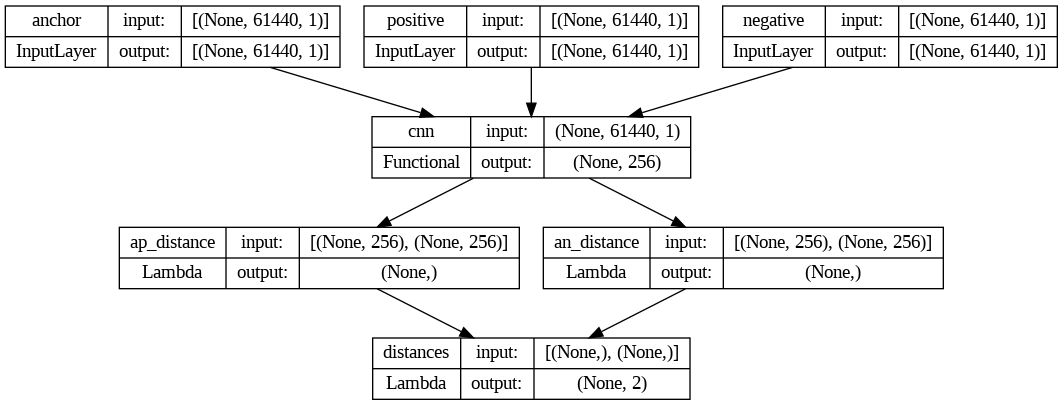

In [ ]:
tfk.utils.plot_model(siamese_network, show_shapes=True, show_layer_names=True) #tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

### Emb1 - margin 0,5

In [ ]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_prova_1_2.npz')
with np.load(path) as data:
  train = data['triplets']

print(train.dtype)

train = np.transpose(train, (0, 2, 1))
X_train = train[:2500]
X_val = train[-500:]

train.shape, X_train.shape, X_val.shape

float16


((3000, 61440, 3), (2500, 61440, 3), (500, 61440, 3))

In [ ]:
del train

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train.shape[0], 2))
dummy_labels_val = np.zeros((X_val.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train[:,:,0], axis=-1), np.expand_dims(X_train[:,:,1], axis=-1), np.expand_dims(X_train[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=30,
    batch_size=16,
    validation_data = ([np.expand_dims(X_val[:,:,0], axis=-1), np.expand_dims(X_val[:,:,1], axis=-1), np.expand_dims(X_val[:,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
157/157 [==============================] - 151s 835ms/step - loss: 1.0003 - val_loss: 0.9910 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 130s 827ms/step - loss: 0.9043 - val_loss: 0.8671 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 131s 836ms/step - loss: 0.8179 - val_loss: 0.8898 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 132s 838ms/step - loss: 0.7331 - val_loss: 0.7648 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 131s 837ms/step - loss: 0.6488 - val_loss: 0.6680 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 132s 838ms/step - loss: 0.5754 - val_loss: 0.7205 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 131s 838ms/step - loss: 0.5077 - val_loss: 0.6814 - lr: 0.0010
Epoch 8/30
157/157 [==============================] - 131s 837ms/step - loss: 0.4523 - val_loss: 0.5610 - lr: 0.0010
Epoch 9/30
157/157 [==============================] - 131s 837ms

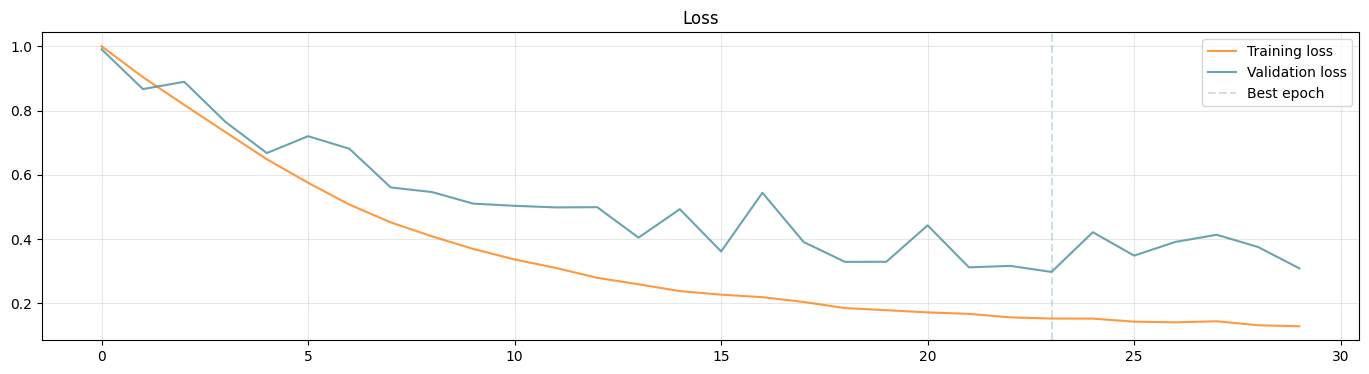

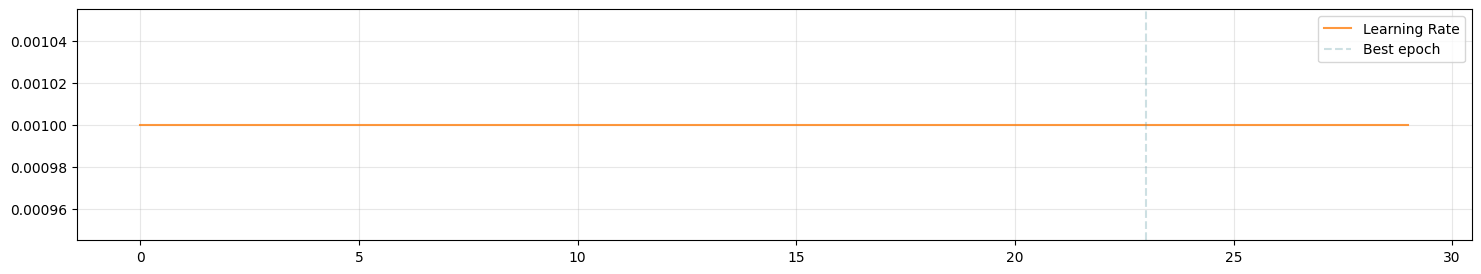

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
siamese_network.save(os.path.join(root_dir, 'Triplets', 'model0_emb1_16'))

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val

79/79 [==============================] - 46s 510ms/step
0.9852
16/16 [==============================] - 9s 616ms/step
0.836


### Emb1 - dropout 0,3

In [ ]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_prova_1_2.npz')
with np.load(path) as data:
  train = data['triplets']

print(train.dtype)

train = np.transpose(train, (0, 2, 1))
X_train = train[:2500]
X_val = train[-500:]

train.shape, X_train.shape, X_val.shape

float16


((3000, 61440, 3), (2500, 61440, 3), (500, 61440, 3))

In [ ]:
del train

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train.shape[0], 2))
dummy_labels_val = np.zeros((X_val.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train[:,:,0], axis=-1), np.expand_dims(X_train[:,:,1], axis=-1), np.expand_dims(X_train[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=30,
    batch_size=16,
    validation_data = ([np.expand_dims(X_val[:,:,0], axis=-1), np.expand_dims(X_val[:,:,1], axis=-1), np.expand_dims(X_val[:,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
157/157 [==============================] - 159s 881ms/step - loss: 0.9811 - val_loss: 0.9760 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 134s 854ms/step - loss: 0.8743 - val_loss: 0.9224 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 137s 870ms/step - loss: 0.7711 - val_loss: 0.7949 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 134s 856ms/step - loss: 0.6819 - val_loss: 0.7835 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 134s 856ms/step - loss: 0.5858 - val_loss: 0.6468 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 134s 855ms/step - loss: 0.4952 - val_loss: 0.6360 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 134s 856ms/step - loss: 0.4276 - val_loss: 0.6343 - lr: 0.0010
Epoch 8/30
157/157 [==============================] - 134s 855ms/step - loss: 0.3674 - val_loss: 0.5279 - lr: 0.0010
Epoch 9/30
157/157 [==============================] - 134s 856ms

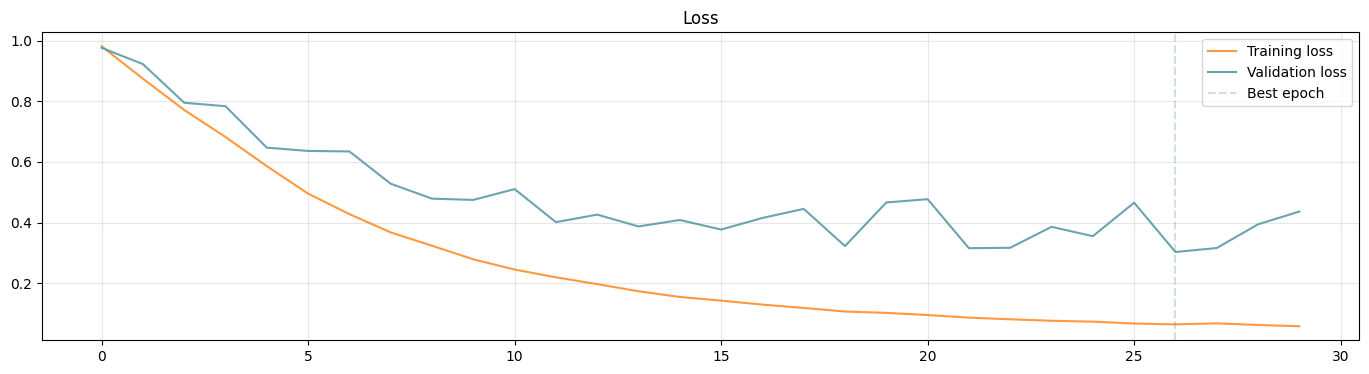

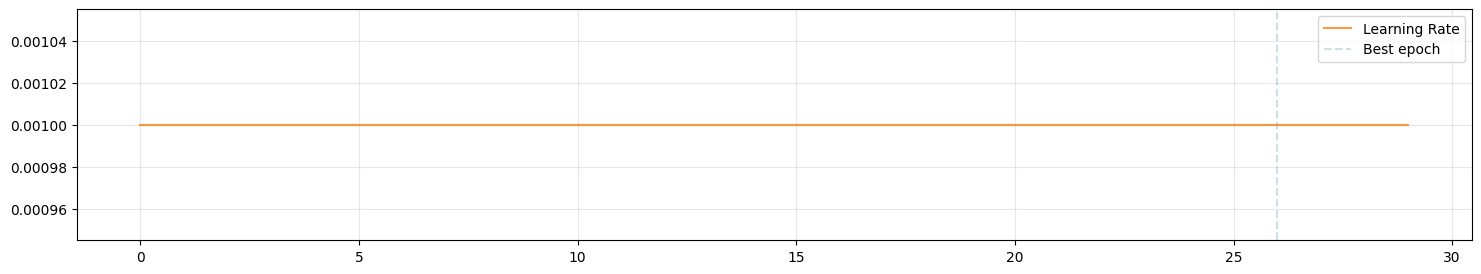

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val

79/79 [==============================] - 43s 498ms/step
0.9168
16/16 [==============================] - 10s 630ms/step
0.718


### Emb1 - margin 0,3

In [ ]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_prova_1_2.npz')
with np.load(path) as data:
  train = data['triplets']

print(train.dtype)

train = np.transpose(train, (0, 2, 1))
X_train = train[:2500]
X_val = train[-500:]

train.shape, X_train.shape, X_val.shape

float16


((3000, 61440, 3), (2500, 61440, 3), (500, 61440, 3))

In [ ]:
del train

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train.shape[0], 2))
dummy_labels_val = np.zeros((X_val.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train[:,:,0], axis=-1), np.expand_dims(X_train[:,:,1], axis=-1), np.expand_dims(X_train[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=30,
    batch_size=16,
    validation_data = ([np.expand_dims(X_val[:,:,0], axis=-1), np.expand_dims(X_val[:,:,1], axis=-1), np.expand_dims(X_val[:,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
157/157 [==============================] - 154s 861ms/step - loss: 0.7935 - val_loss: 0.7882 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 131s 835ms/step - loss: 0.7026 - val_loss: 0.7190 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 131s 833ms/step - loss: 0.6027 - val_loss: 0.6185 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 133s 851ms/step - loss: 0.5023 - val_loss: 0.6303 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 131s 834ms/step - loss: 0.4171 - val_loss: 0.5721 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 131s 834ms/step - loss: 0.3551 - val_loss: 0.4928 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 131s 833ms/step - loss: 0.2989 - val_loss: 0.3998 - lr: 0.0010
Epoch 8/30
157/157 [==============================] - 133s 850ms/step - loss: 0.2528 - val_loss: 0.3717 - lr: 0.0010
Epoch 9/30
157/157 [==============================] - 131s 833ms

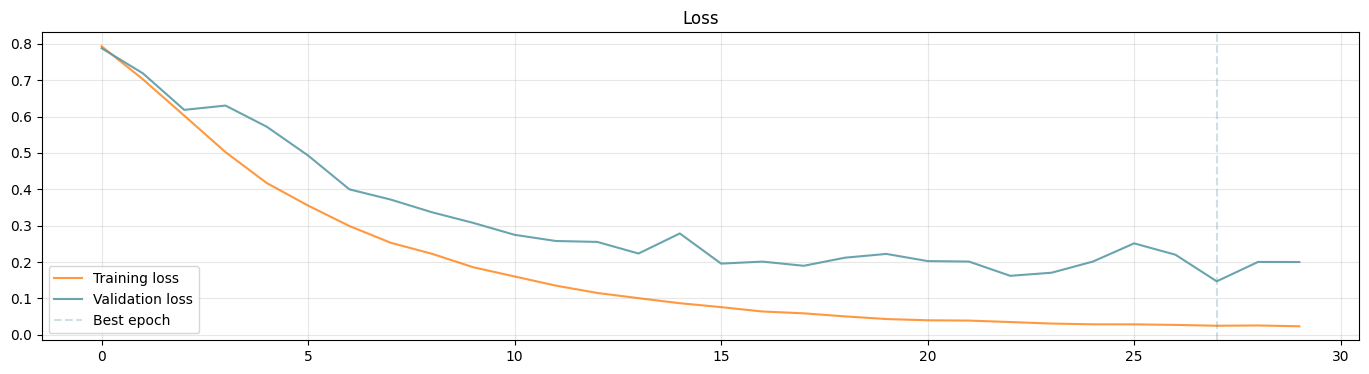

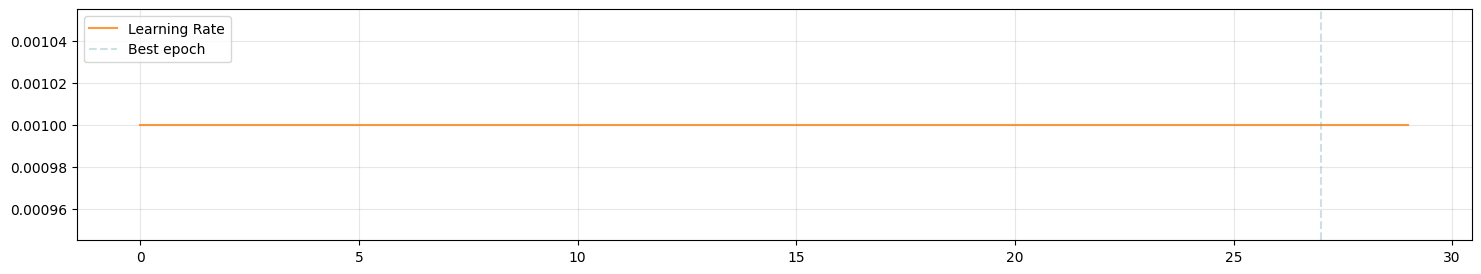

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val

79/79 [==============================] - 43s 482ms/step
0.9752
16/16 [==============================] - 10s 693ms/step
0.766


### Emb1 - margin 0,7


In [ ]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_prova_1_2.npz')
with np.load(path) as data:
  train = data['triplets']

print(train.dtype)

train = np.transpose(train, (0, 2, 1))
X_train = train[:2500]
X_val = train[-500:]

train.shape, X_train.shape, X_val.shape

float16


((3000, 61440, 3), (2500, 61440, 3), (500, 61440, 3))

In [ ]:
del train

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train.shape[0], 2))
dummy_labels_val = np.zeros((X_val.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train[:,:,0], axis=-1), np.expand_dims(X_train[:,:,1], axis=-1), np.expand_dims(X_train[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=30,
    batch_size=16,
    validation_data = ([np.expand_dims(X_val[:,:,0], axis=-1), np.expand_dims(X_val[:,:,1], axis=-1), np.expand_dims(X_val[:,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
157/157 [==============================] - 149s 828ms/step - loss: 1.0045 - val_loss: 0.9871 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 132s 839ms/step - loss: 0.9289 - val_loss: 0.8811 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 129s 823ms/step - loss: 0.8341 - val_loss: 0.8230 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 132s 840ms/step - loss: 0.7564 - val_loss: 0.7668 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 129s 823ms/step - loss: 0.6818 - val_loss: 0.7003 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 129s 822ms/step - loss: 0.6089 - val_loss: 0.6348 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 129s 824ms/step - loss: 0.5381 - val_loss: 0.6184 - lr: 0.0010
Epoch 8/30
157/157 [==============================] - 129s 822ms/step - loss: 0.4800 - val_loss: 0.6207 - lr: 0.0010
Epoch 9/30
157/157 [==============================] - 129s 822ms

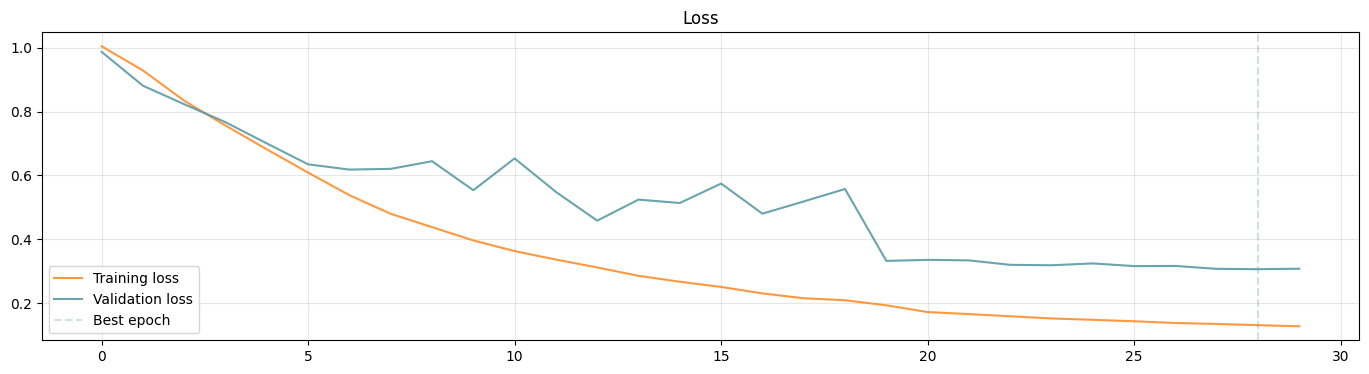

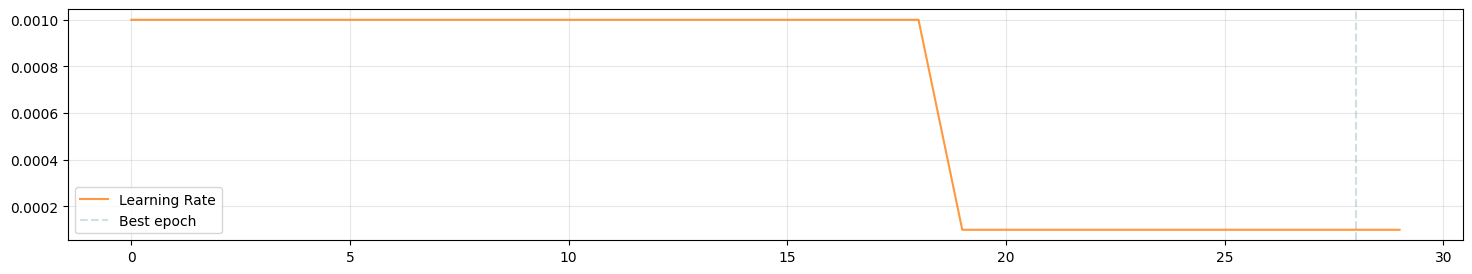

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val

79/79 [==============================] - 43s 481ms/step
0.9976
16/16 [==============================] - 9s 587ms/step
0.878


In [ ]:
siamese_network.save(os.path.join(root_dir, 'Triplets', 'model0_emb1_margin_0_3'))

### Emb1 - margin 0,9


In [ ]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_prova_1_2.npz')
with np.load(path) as data:
  train = data['triplets']

print(train.dtype)

train = np.transpose(train, (0, 2, 1))
X_train = train[:2500]
X_val = train[-500:]

train.shape, X_train.shape, X_val.shape

float16


((3000, 61440, 3), (2500, 61440, 3), (500, 61440, 3))

In [ ]:
del train

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train.shape[0], 2))
dummy_labels_val = np.zeros((X_val.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train[:,:,0], axis=-1), np.expand_dims(X_train[:,:,1], axis=-1), np.expand_dims(X_train[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=30,
    batch_size=16,
    validation_data = ([np.expand_dims(X_val[:,:,0], axis=-1), np.expand_dims(X_val[:,:,1], axis=-1), np.expand_dims(X_val[:,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
157/157 [==============================] - 149s 831ms/step - loss: 1.4029 - val_loss: 1.3958 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 131s 836ms/step - loss: 1.2909 - val_loss: 1.3616 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 128s 818ms/step - loss: 1.1677 - val_loss: 1.3212 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 129s 819ms/step - loss: 1.0784 - val_loss: 1.2049 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 128s 818ms/step - loss: 1.0238 - val_loss: 1.0198 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 128s 816ms/step - loss: 0.9590 - val_loss: 1.2356 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 128s 818ms/step - loss: 0.9073 - val_loss: 1.2183 - lr: 0.0010
Epoch 8/30
157/157 [==============================] - 128s 818ms/step - loss: 0.8684 - val_loss: 0.8982 - lr: 0.0010
Epoch 9/30
157/157 [==============================] - 128s 817ms

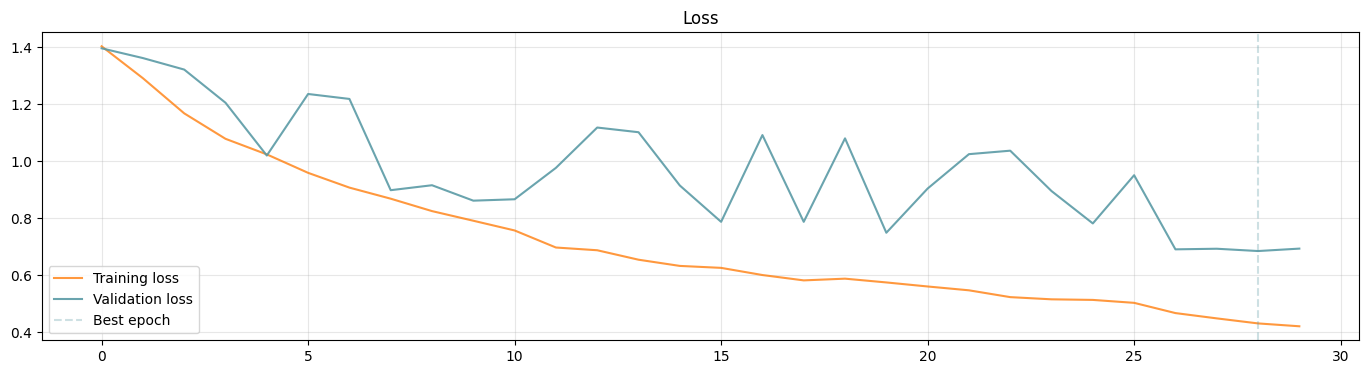

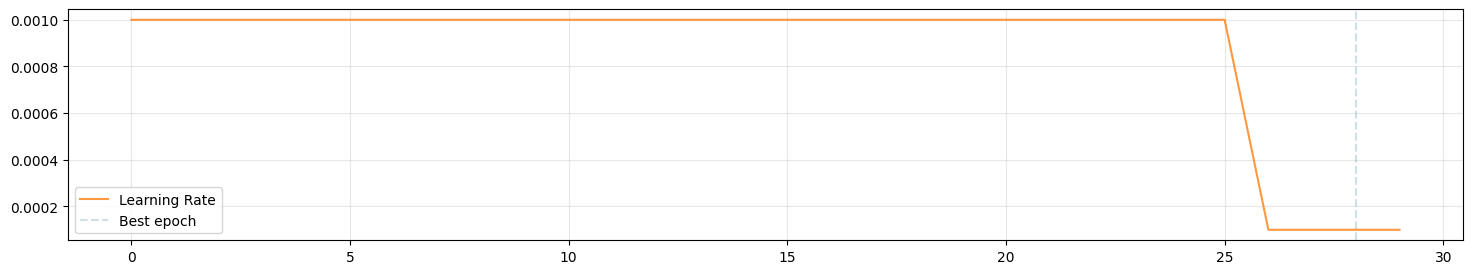

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val

79/79 [==============================] - 42s 472ms/step
0.9336
16/16 [==============================] - 9s 589ms/step
0.724


In [ ]:
siamese_network.save(os.path.join(root_dir, 'Triplets', 'model0_emb1_margin_0_3'))

### Emb1 - cross validation


In [6]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_prova_1_2.npz')
with np.load(path) as data:
  train = data['triplets']

print(train.dtype)

train = np.transpose(train, (0, 2, 1))
X1 = train[:1000]
X2 = train[1000:2000]
X3 = train[-1000:]

X1.shape, X2.shape, X3.shape, np.concatenate((X1,X2), axis=0).shape

float16


((1000, 61440, 3), (1000, 61440, 3), (1000, 61440, 3), (2000, 61440, 3))

In [ ]:
del train

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train.shape[0], 2))
dummy_labels_val = np.zeros((X_val.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train[:,:,0], axis=-1), np.expand_dims(X_train[:,:,1], axis=-1), np.expand_dims(X_train[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=30,
    batch_size=16,
    validation_data = ([np.expand_dims(X_val[:,:,0], axis=-1), np.expand_dims(X_val[:,:,1], axis=-1), np.expand_dims(X_val[:,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
157/157 [==============================] - 149s 831ms/step - loss: 1.4029 - val_loss: 1.3958 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 131s 836ms/step - loss: 1.2909 - val_loss: 1.3616 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 128s 818ms/step - loss: 1.1677 - val_loss: 1.3212 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 129s 819ms/step - loss: 1.0784 - val_loss: 1.2049 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 128s 818ms/step - loss: 1.0238 - val_loss: 1.0198 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 128s 816ms/step - loss: 0.9590 - val_loss: 1.2356 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 128s 818ms/step - loss: 0.9073 - val_loss: 1.2183 - lr: 0.0010
Epoch 8/30
157/157 [==============================] - 128s 818ms/step - loss: 0.8684 - val_loss: 0.8982 - lr: 0.0010
Epoch 9/30
157/157 [==============================] - 128s 817ms

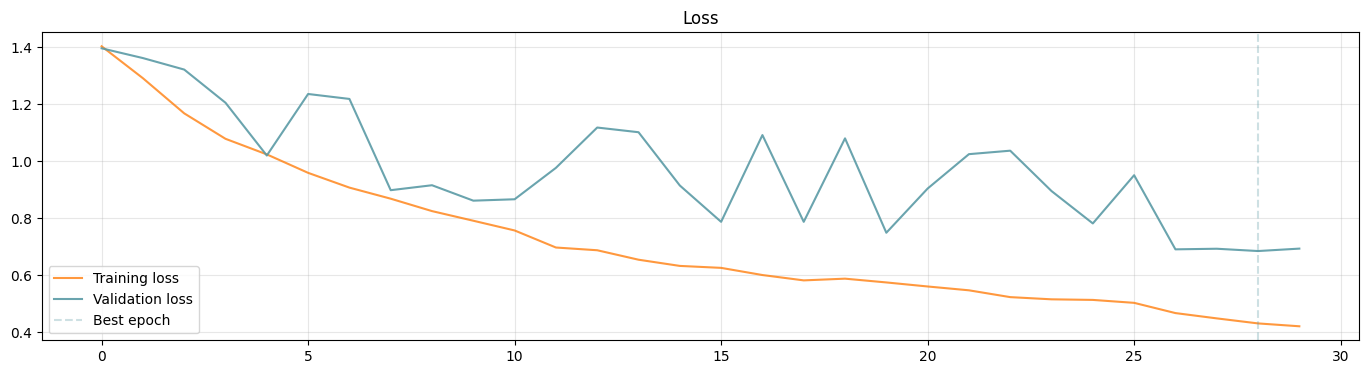

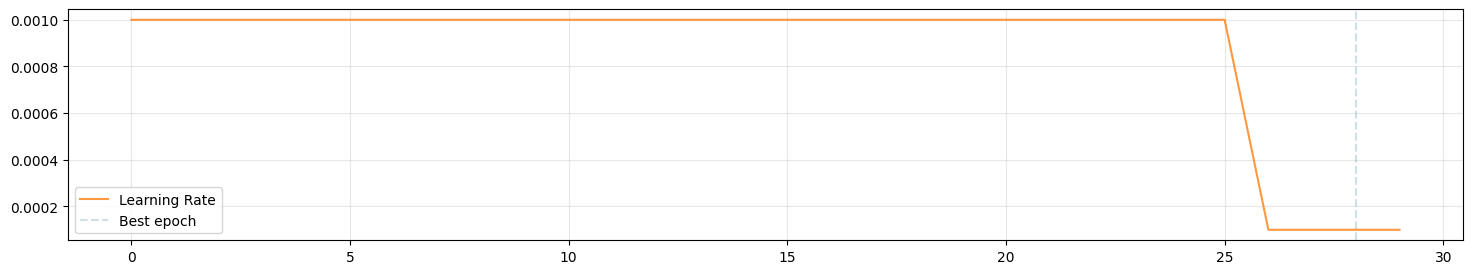

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val

79/79 [==============================] - 42s 472ms/step
0.9336
16/16 [==============================] - 9s 589ms/step
0.724


In [ ]:
siamese_network.save(os.path.join(root_dir, 'Triplets', 'model0_emb1_margin_0_3'))

### Emb2

In [ ]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_prova_2_2.npz')
with np.load(path) as data:
  train = data['triplets']

print(train.dtype)

train = np.transpose(train, (0, 2, 1))
X_train = train[:2500]
X_val = train[-500:]

train.shape, X_train.shape, X_val.shape

float16


((3000, 61440, 3), (2500, 61440, 3), (500, 61440, 3))

In [ ]:
del train

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train.shape[0], 2))
dummy_labels_val = np.zeros((X_val.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train[:,:,0], axis=-1), np.expand_dims(X_train[:,:,1], axis=-1), np.expand_dims(X_train[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=30,
    batch_size=16,
    validation_data = ([np.expand_dims(X_val[:,:,0], axis=-1), np.expand_dims(X_val[:,:,1], axis=-1), np.expand_dims(X_val[:,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
157/157 [==============================] - 155s 850ms/step - loss: 0.9877 - val_loss: 0.9908 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 130s 828ms/step - loss: 0.8846 - val_loss: 0.8482 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 133s 845ms/step - loss: 0.7877 - val_loss: 0.8761 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 130s 828ms/step - loss: 0.7008 - val_loss: 0.7231 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 130s 828ms/step - loss: 0.6168 - val_loss: 0.6531 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 132s 844ms/step - loss: 0.5450 - val_loss: 0.6901 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 133s 844ms/step - loss: 0.4910 - val_loss: 0.5500 - lr: 0.0010
Epoch 8/30
157/157 [==============================] - 132s 844ms/step - loss: 0.4395 - val_loss: 0.5605 - lr: 0.0010
Epoch 9/30
157/157 [==============================] - 130s 827ms

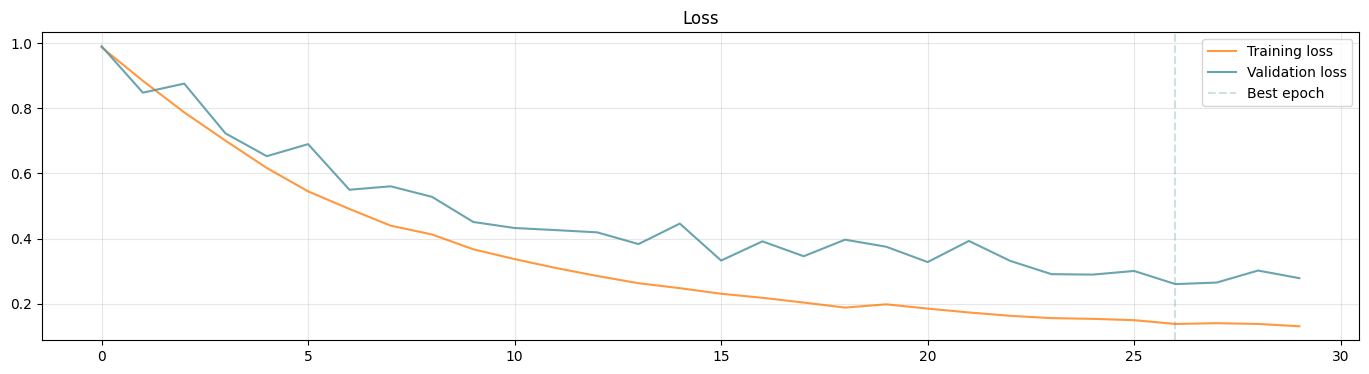

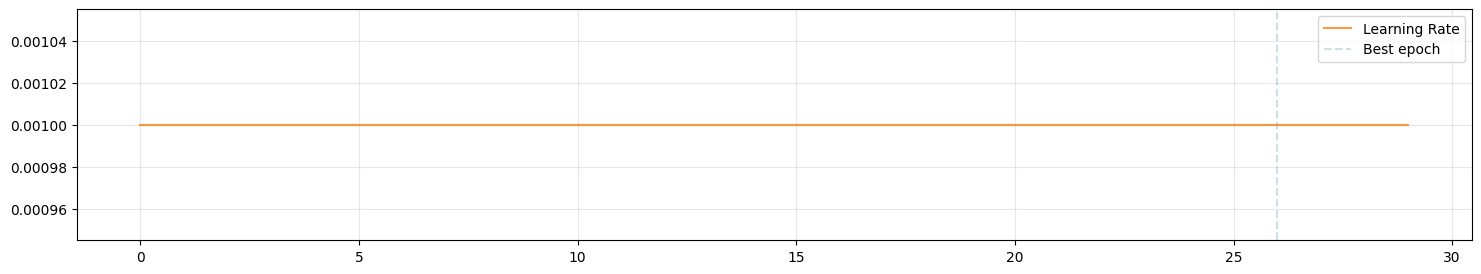

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
siamese_network.save(os.path.join(root_dir, 'Triplets', 'model0_emb2_16'))

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val

79/79 [==============================] - 41s 476ms/step
0.9956
16/16 [==============================] - 11s 701ms/step
0.86


### Emb3

In [ ]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_prova_3_2.npz')
with np.load(path) as data:
  train = data['triplets']

print(train.dtype)

train = np.transpose(train, (0, 2, 1))
X_train = train[:2500]
X_val = train[-500:]

train.shape, X_train.shape, X_val.shape

float16


((3000, 61440, 3), (2500, 61440, 3), (500, 61440, 3))

In [ ]:
del train

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train.shape[0], 2))
dummy_labels_val = np.zeros((X_val.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train[:,:,0], axis=-1), np.expand_dims(X_train[:,:,1], axis=-1), np.expand_dims(X_train[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=30,
    batch_size=16,
    validation_data = ([np.expand_dims(X_val[:,:,0], axis=-1), np.expand_dims(X_val[:,:,1], axis=-1), np.expand_dims(X_val[:,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
157/157 [==============================] - 153s 844ms/step - loss: 0.9909 - val_loss: 0.9896 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 129s 821ms/step - loss: 0.8605 - val_loss: 0.9201 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 129s 821ms/step - loss: 0.7666 - val_loss: 0.8313 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 129s 821ms/step - loss: 0.6763 - val_loss: 0.7405 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 129s 820ms/step - loss: 0.5988 - val_loss: 0.6545 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 132s 839ms/step - loss: 0.5313 - val_loss: 0.6039 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 132s 840ms/step - loss: 0.4729 - val_loss: 0.5182 - lr: 0.0010
Epoch 8/30
157/157 [==============================] - 129s 822ms/step - loss: 0.4281 - val_loss: 0.5752 - lr: 0.0010
Epoch 9/30
157/157 [==============================] - 129s 821ms

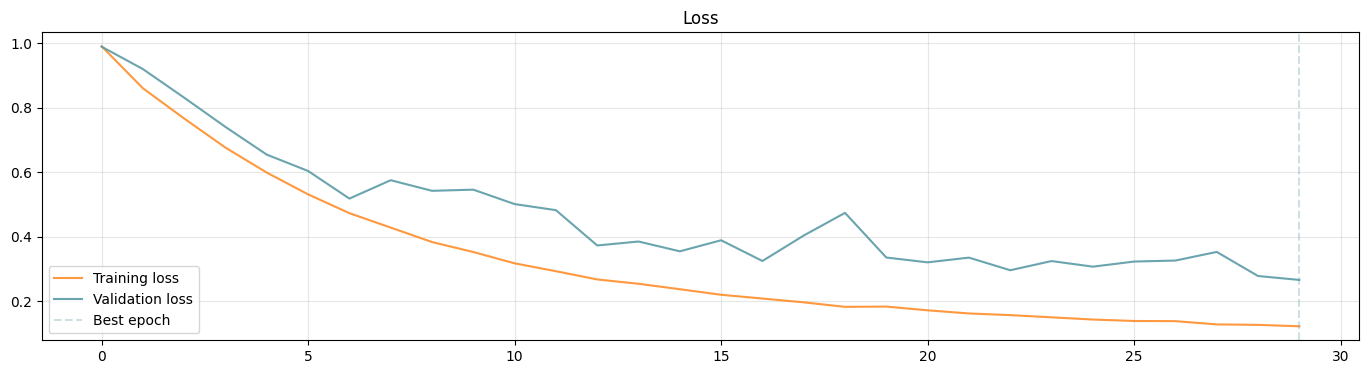

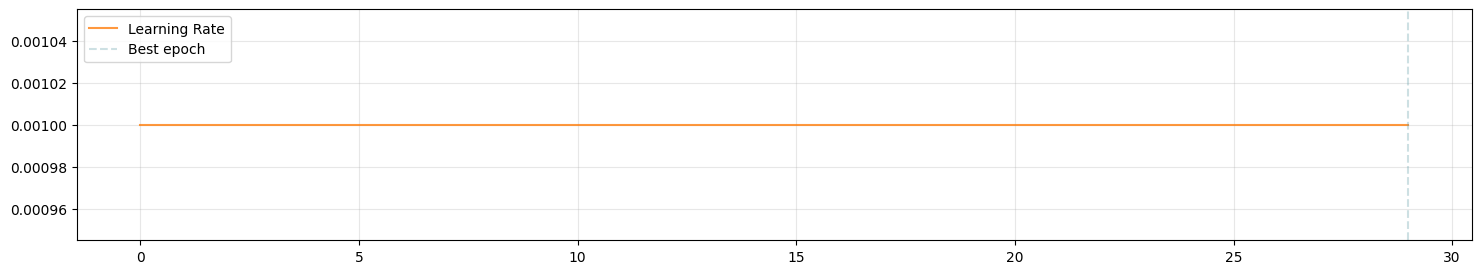

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
siamese_network.save(os.path.join(root_dir, 'Triplets', 'model0_emb3_16'))

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val

79/79 [==============================] - 43s 479ms/step
0.9964
16/16 [==============================] - 10s 689ms/step
0.868


### Emb4

In [ ]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_prova_4_2.npz')
with np.load(path) as data:
  train = data['triplets']

print(train.dtype)

train = np.transpose(train, (0, 2, 1))
X_train = train[:2500]
X_val = train[-500:]

train.shape, X_train.shape, X_val.shape

float16


((3000, 61440, 3), (2500, 61440, 3), (500, 61440, 3))

In [ ]:
del train

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train.shape[0], 2))
dummy_labels_val = np.zeros((X_val.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train[:,:,0], axis=-1), np.expand_dims(X_train[:,:,1], axis=-1), np.expand_dims(X_train[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=30,
    batch_size=16,
    validation_data = ([np.expand_dims(X_val[:,:,0], axis=-1), np.expand_dims(X_val[:,:,1], axis=-1), np.expand_dims(X_val[:,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/30
157/157 [==============================] - 158s 868ms/step - loss: 0.9902 - val_loss: 0.9882 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 132s 844ms/step - loss: 0.8781 - val_loss: 0.8653 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 132s 843ms/step - loss: 0.7863 - val_loss: 0.8981 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 132s 843ms/step - loss: 0.7103 - val_loss: 0.7253 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 132s 844ms/step - loss: 0.6389 - val_loss: 0.7338 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 133s 845ms/step - loss: 0.5855 - val_loss: 0.7276 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 132s 843ms/step - loss: 0.5259 - val_loss: 0.6014 - lr: 0.0010
Epoch 8/30
157/157 [==============================] - 132s 844ms/step - loss: 0.4801 - val_loss: 0.6697 - lr: 0.0010
Epoch 9/30
157/157 [==============================] - 132s 844ms

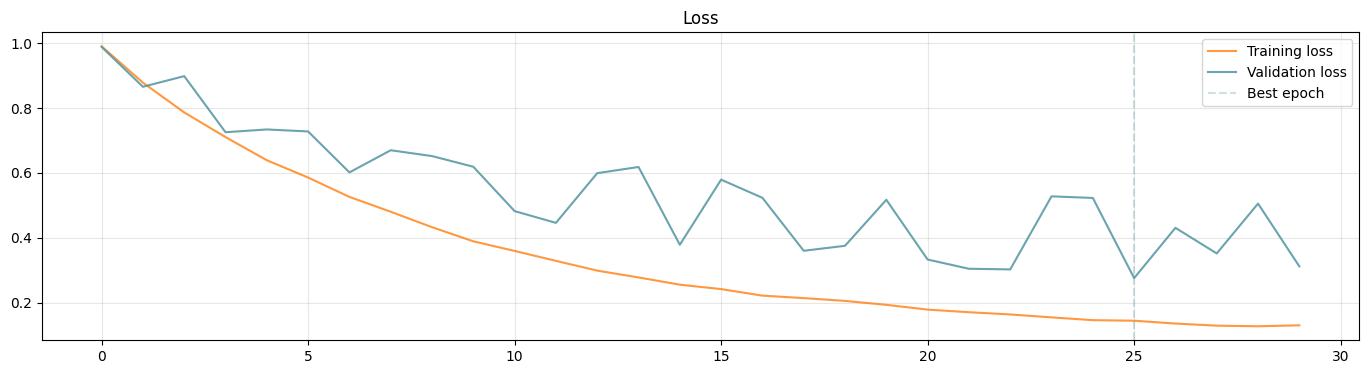

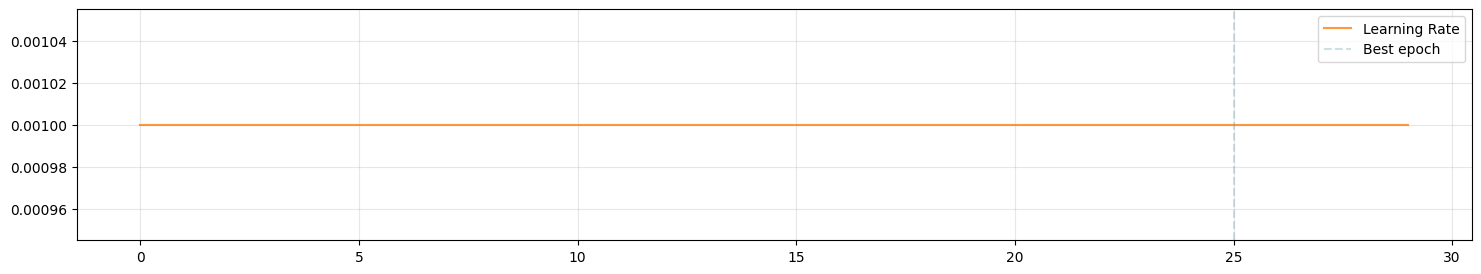

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
siamese_network.save(os.path.join(root_dir, 'Triplets', 'model0_emb4_16'))

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val

79/79 [==============================] - 42s 492ms/step
0.9808
16/16 [==============================] - 11s 705ms/step
0.834


### AllMusic_triplets


In [ ]:
root_dir = os.getcwd()
path = os.path.join(root_dir, 'Triplets', 'triplets_music.npz')
with np.load(path) as data:
  train = data['triplets']

train = np.transpose(train, (0, 2, 1))
np.random.shuffle(train)
X_train = train[:15000]
X_val = train[-2673:]

train.shape, X_train.shape, X_val.shape

((17673, 61440, 3), (15000, 61440, 3), (2673, 61440, 3))

In [ ]:
del train

In [ ]:
X_train1 = X_train[:5000]
X_train2 = X_train[5000:10000]
X_train3 = X_train[10000:15000]
del X_train
del X_val
X_train1.shape, X_train2.shape, X_train3.shape

((5000, 61440, 3), (5000, 61440, 3), (5000, 61440, 3))

In [ ]:
''' the .fit method expects a set of labels (y_true) for supervised learning.
Since we are using a custom loss function that doesn't actually use these labels, we can provide "dummy labels" to satisfy the method's requirement.
Dummy labels are essentially placeholders that don't contain meaningful data, but allow the training process to proceed without errors.'''

dummy_labels_train = np.zeros((X_train1.shape[0], 2))
dummy_labels_val = np.zeros((X_train1.shape[0], 2))

history = siamese_network.fit(
    x = [np.expand_dims(X_train1[:,:,0], axis=-1), np.expand_dims(X_train1[:,:,1], axis=-1), np.expand_dims(X_train1[:,:,2], axis=-1)],
    y = dummy_labels_train,
    epochs=20,
    batch_size=8,
    validation_data = ([np.expand_dims(X_train2[:500,:,0], axis=-1), np.expand_dims(X_train2[:500,:,1], axis=-1), np.expand_dims(X_train2[:500,:,2], axis=-1)], dummy_labels_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.1, min_lr=1e-5)
    ]
).history

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
siamese_network.save(os.path.join(root_dir, 'Triplets', 'model0_music'))

In [ ]:
# Load the model
'''siamese_network = tf.keras.models.load_model(
    os.path.join(root_dir, 'Triplets', 'first_model'),
    custom_objects={'triplet_loss': triplet_loss}  # Ensure to provide custom objects if any
)
'''
accuracy_train = compute_triplet_accuracy(siamese_network, X_train)
print(accuracy_train)
del accuracy_train
accuracy_val = compute_triplet_accuracy(siamese_network, X_val)
print(accuracy_val)
del accuracy_val